In [4]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, deque
from sklearn.cluster import KMeans

In [ ]:
# Load data and preprocess
df = pd.read_csv("df_merged.csv")

df["reward"] = (df["Rating"] - 1.0) / 4.0

user_ids = df["UserID"].unique()
movie_ids = df["MovieID"].unique()

u2i = {u: i for i, u in enumerate(user_ids)}
m2i = {m: i for i, m in enumerate(movie_ids)}
i2m = {i: m for m, i in m2i.items()}

df["u_idx"] = df["UserID"].map(u2i).astype(int)
df["m_idx"] = df["MovieID"].map(m2i).astype(int)

n_users = len(user_ids)
n_items = len(movie_ids)

print(f"Users: {n_users}, Items: {n_items}, Ratings: {len(df)}")

# Rating lookup dictionary
rating_dict = {
    (int(u), int(m)): float(r)
    for u, m, r in df[["u_idx", "m_idx", "reward"]].to_numpy()
}

# Stream of events ordered by time
events = (
    df.sort_values("Timestamp")[["u_idx", "m_idx", "reward"]]
      .to_numpy()
)


Users: 6040, Items: 3706, Ratings: 1000209


In [6]:
# Create sparse matrix
R = sparse.coo_matrix(
    (df["reward"].values, (df["u_idx"].values, df["m_idx"].values)),
    shape=(n_users, n_items)
).tocsr()

# Item embeddings with SVD
d = 30  # latent dimension
svd = TruncatedSVD(n_components=d, random_state=0)
item_factors = svd.fit_transform(R.T)

# Normalize (important for LinUCB)
item_factors = item_factors / (np.linalg.norm(item_factors, axis=1, keepdims=True) + 1e-12)

# Initial item partition
K = 50
kmeans = KMeans(n_clusters=K, random_state=0, n_init="auto")
item_cluster = kmeans.fit_predict(item_factors)

cluster_items = {
    c: np.where(item_cluster == c)[0]
    for c in range(K)
}


In [ ]:
class DC3MABLike:
    """
    DC³MAB-like bandit for recommendation (MovieLens-style).
    """

    def __init__(
        self,
        n_users: int,
        item_factors: np.ndarray,
        item_cluster: np.ndarray = None,
        cluster_items: dict = None,
        alpha: float = 0.6,
        lam: float = 1.0,
        edge_init: str = "kmeans",
        user_init_clusters: int = 50,
        split_beta_scale: float = 1.0,
        delta: float = 0.1,
        recluster_every: int = 5000,
        item_clusters_k: int = None,
        augment_item_with_counts: bool = True,
        seed: int = 0,
    ):
        # RNG
        self.rng = np.random.default_rng(seed)

        # Users
        self.n_users = int(n_users)

        # Items + features (used as linear bandit "contexts")
        self.X = np.asarray(item_factors, dtype=float)
        self.n_items = int(self.X.shape[0])
        self.d = int(self.X.shape[1])

        # LinUCB params
        self.alpha = float(alpha)
        self.lam = float(lam)

        # Split confidence params (LinUCB-style)
        self.split_beta_scale = float(split_beta_scale)
        self.delta = float(delta)

        # Per-user linear stats
        self.A = np.array([np.eye(self.d) * self.lam for _ in range(self.n_users)])
        self.b = np.zeros((self.n_users, self.d))
        self.t = np.zeros(self.n_users, dtype=int)

        # Item partition dynamics
        self.recluster_every = None if recluster_every is None else int(recluster_every)
        self.global_updates = 0
        self.augment_item_with_counts = bool(augment_item_with_counts)
        self.item_counts = np.zeros(self.n_items, dtype=float)

        # Determine K for item clusters
        if item_clusters_k is None:
            if cluster_items is not None:
                item_clusters_k = len(cluster_items)
            elif item_cluster is not None:
                item_clusters_k = int(np.max(item_cluster)) + 1
            else:
                item_clusters_k = 100
        self.item_clusters_k = int(item_clusters_k)

        # Initialize item partition
        if cluster_items is not None and item_cluster is not None:
            self.item_cluster = np.asarray(item_cluster, dtype=int)
            self.cluster_items = {int(k): np.asarray(v, dtype=int) for k, v in cluster_items.items()}
        else:
            if item_cluster is None:
                self.recluster_items(n_clusters=self.item_clusters_k)
            else:
                self.item_cluster = np.asarray(item_cluster, dtype=int)
                self._rebuild_cluster_items()

        self.K = len(self.cluster_items)

        # User graph for dynamic clustering
        self.G = [set() for _ in range(self.n_users)]
        self.init_graph(edge_init=edge_init, user_init_clusters=user_init_clusters)

    # User graph initialization
    def init_graph(self, edge_init: str, user_init_clusters: int):
        edge_init = str(edge_init).lower()
        if edge_init == "full":
            all_users = set(range(self.n_users))
            for u in range(self.n_users):
                self.G[u] = all_users - {u}
            return

        # Placeholder: random user embeddings; replace with real user embeddings if info about them
        user_emb = self.rng.normal(size=(self.n_users, self.d))
        km = KMeans(n_clusters=int(user_init_clusters), random_state=0, n_init="auto")
        ucl = km.fit_predict(user_emb)

        groups = defaultdict(list)
        for u, c in enumerate(ucl):
            groups[int(c)].append(int(u))

        for us in groups.values():
            s = set(us)
            for u in us:
                self.G[u] = s - {u}

    def theta_user(self, u: int) -> np.ndarray:
        u = int(u)
        # Prototype: explicit inverse.
        Ainv = np.linalg.inv(self.A[u])
        return Ainv @ self.b[u]

    def cluster_of(self, u: int):
        """Connected component containing u."""
        u = int(u)
        seen = {u}
        q = deque([u])
        while q:
            x = q.popleft()
            for y in self.G[x]:
                if y not in seen:
                    seen.add(y)
                    q.append(y)
        return list(seen)

    def cluster_model(self, cluster_users):
        """Pool A,b over users in cluster and return (theta_hat, Ainv_cluster)."""
        A_sum = np.zeros((self.d, self.d))
        b_sum = np.zeros(self.d)
        for v in cluster_users:
            A_sum += self.A[v]
            b_sum += self.b[v]
        A_sum = A_sum + 1e-12 * np.eye(self.d)
        Ainv = np.linalg.inv(A_sum)
        theta = Ainv @ b_sum
        return theta, Ainv

    # LinUCB-style confidence for splitting
    def _beta(self, u: int) -> float:
        """
        LinUCB beta term (safe form).
        Assumes ||theta|| <= S and ||x|| <= L. Here: S=1, L=1 by default.
        Tune split_beta_scale to adjust aggressiveness.
        """
        u = int(u)
        t = max(int(self.t[u]), 1)
        d = self.d
        lam = self.lam
        delta = self.delta

        S = 1.0  # bound on ||theta||
        L = 1.0  # bound on ||x||

        return self.split_beta_scale * (
            S * np.sqrt(lam)
            + L * np.sqrt(2.0 * np.log(1.0 / delta) + d * np.log(1.0 + t * (L * L) / lam))
        )

    def _radius_l2(self, u: int) -> float:
        """
        Convert ellipsoidal confidence to coarse L2 radius via trace(A^{-1}).
        """
        u = int(u)
        Ainv = np.linalg.inv(self.A[u])
        return self._beta(u) * np.sqrt(np.trace(Ainv))

    # Item partitioning
    def _rebuild_cluster_items(self):
        cluster_items = defaultdict(list)
        for it, c in enumerate(self.item_cluster):
            cluster_items[int(c)].append(int(it))
        self.cluster_items = {k: np.asarray(v, dtype=int) for k, v in cluster_items.items()}
        self.K = len(self.cluster_items)

    def recluster_items(self, n_clusters: int = None):
        """
        Recluster items using KMeans on item factors (optionally augmented by interaction counts).
        """
        if n_clusters is None:
            n_clusters = self.item_clusters_k
        n_clusters = int(n_clusters)

        if self.augment_item_with_counts:
            counts = self.item_counts.reshape(-1, 1)
            counts = counts / (counts.max() + 1e-12)
            Z = np.hstack([self.X, counts])
        else:
            Z = self.X

        km = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
        new_item_cluster = km.fit_predict(Z)

        self.item_cluster = new_item_cluster.astype(int)
        self._rebuild_cluster_items()

    def recommend(self, u: int, L: int = 10, per_cluster: int = 2, candidate_clusters: int = 10):
        """
        Recommend a list of L items.

        Step 1: score item-clusters using UCB on cluster centroids.
        Step 2: within each candidate cluster, pick top items by UCB.
        """
        u = int(u)
        L = int(L)
        per_cluster = int(per_cluster)
        candidate_clusters = int(candidate_clusters)

        cu = self.cluster_of(u)
        theta_c, Ainv_c = self.cluster_model(cu)

        # Build centroids for item clusters
        K = self.K
        cent = np.zeros((K, self.d))
        for k in range(K):
            items = self.cluster_items.get(k, None)
            if items is not None and len(items) > 0:
                cent[k] = self.X[items].mean(axis=0)

        # Normalize centroids to stabilize UCB
        cent = cent / (np.linalg.norm(cent, axis=1, keepdims=True) + 1e-12)

        mu = cent @ theta_c
        unc = np.sqrt(np.einsum("ij,jk,ik->i", cent, Ainv_c, cent))
        ucb = mu + self.alpha * unc

        topK = np.argsort(-ucb)[: min(candidate_clusters, K)]

        recs = []
        seen_items = set()

        for k in topK:
            items = self.cluster_items.get(int(k), None)
            if items is None or len(items) == 0:
                continue

            Xk = self.X[items]
            mu_i = Xk @ theta_c
            unc_i = np.sqrt(np.einsum("ij,jk,ik->i", Xk, Ainv_c, Xk))
            ucb_i = mu_i + self.alpha * unc_i

            best = items[np.argsort(-ucb_i)[:per_cluster]]
            for it in best:
                it = int(it)
                if it not in seen_items:
                    recs.append(it)
                    seen_items.add(it)
                if len(recs) >= L:
                    return recs[:L]

        # Fill if not enough items (only for extreme cases)
        if len(recs) < L:
            remaining = L - len(recs)
            fill = self.rng.choice(self.n_items, size=min(remaining, self.n_items), replace=False).tolist()
            for it in fill:
                it = int(it)
                if it not in seen_items:
                    recs.append(it)
                if len(recs) >= L:
                    break

        return recs[:L]

    def update(self, u: int, item: int, reward: float):
        """
        Update the per-user linear model with the observed (u, item, reward),
        then:
          - cut user-user edges if models diverge beyond LinUCB confidence
          - periodically recluster items (dynamic partition)
        """
        u = int(u)
        item = int(item)
        reward = float(reward)

        x = self.X[item]

        # Update user stats
        self.A[u] += np.outer(x, x)
        self.b[u] += reward * x
        self.t[u] += 1

        # Track item interactions for dynamic partitioning
        self.item_counts[item] += 1.0

        # Dynamic user clustering
        theta_u = self.theta_user(u)
        rad_u = self._radius_l2(u)

        to_remove = []
        for v in list(self.G[u]):
            v = int(v)
            theta_v = self.theta_user(v)
            rad_v = self._radius_l2(v)

            if np.linalg.norm(theta_u - theta_v) > (rad_u + rad_v):
                to_remove.append(v)

        for v in to_remove:
            self.G[u].discard(v)
            self.G[v].discard(u)

        # Dynamic item partitioning
        self.global_updates += 1
        if self.recluster_every is not None and self.global_updates % self.recluster_every == 0:
            self.recluster_items(n_clusters=self.item_clusters_k)


In [8]:
# Regret
def regret_custom(u: int, recs, rating_dict):
    """
    Offline proxy regret:
    mean_{m in recs ∩ observed(u)} (1 - rating(u,m))
    """
    s, n = 0.0, 0
    for m in recs:
        key = (int(u), int(m))
        if key in rating_dict:
            n += 1
            s += (1.0 - rating_dict[key])
    if n == 0:
        return 0.0, 0
    return s / n, n

In [9]:
bandit = DC3MABLike(
    n_users=n_users,
    item_factors=item_factors,
    item_cluster=item_cluster,
    cluster_items=cluster_items,
    alpha=0.6,
    lam=1.0,
    edge_init="kmeans",
    user_init_clusters=30,
    split_beta_scale=1.2,
    delta=0.1,
    recluster_every=5000,
    item_clusters_k=K,
    augment_item_with_counts=True,
    seed=0
)

# Run bandit
T = 100_000
L = 10

regret = np.zeros(T)
coverage = np.zeros(T)
avg_degree = np.zeros(T)

for t in range(T):
    if t % 5000 == 0:
        print(t)

    u, true_item, r = events[t]
    u = int(u); true_item = int(true_item); r = float(r)

    recs = bandit.recommend(u, L=L, per_cluster=2, candidate_clusters=10)

    reg_t, cov_t = regret_custom(u, recs, rating_dict)
    regret[t] = reg_t
    coverage[t] = cov_t

    bandit.update(u, true_item, r)

    avg_degree[t] = np.mean([len(nei) for nei in bandit.G])

# Metrics
cum_regret = np.cumsum(regret)
avg_coverage = np.cumsum(coverage) / (np.arange(T) + 1)
avg_degree = np.cumsum(avg_degree) / (np.arange(T) + 1)

print(f"Final cumulated proxy-regret: {cum_regret[-1]:.2f}")
print(f"Average coverage: {avg_coverage[-1]:.2f} / {L}")
print(f"Average user-graph degree: {avg_degree[-1]:.2f}")


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
Final cumulated proxy-regret: 21941.94
Average coverage: 4.26 / 10
Average user-graph degree: 201.41


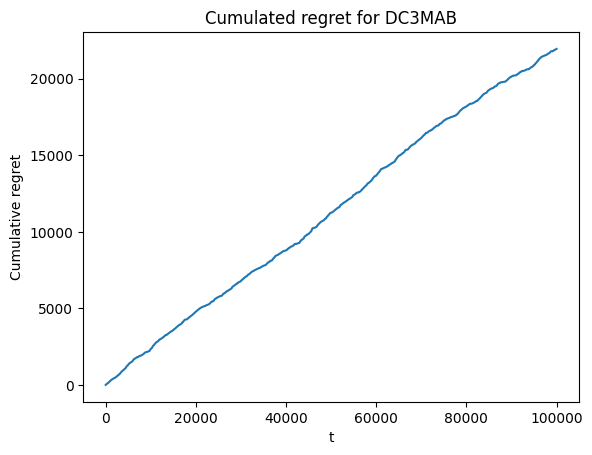

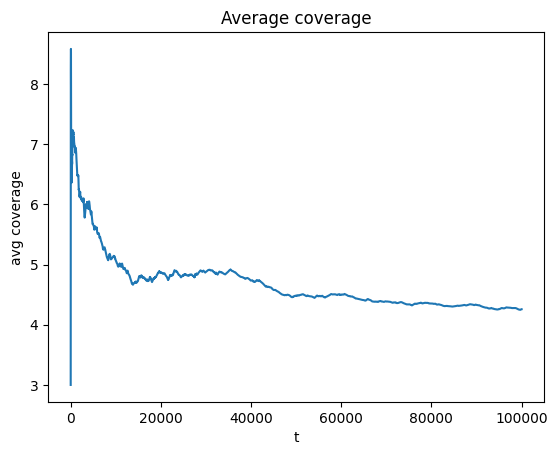

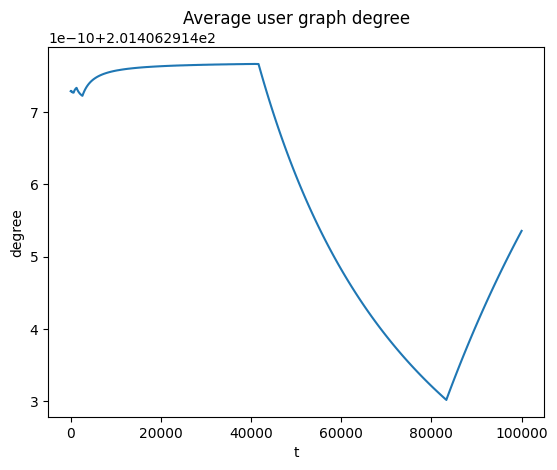

In [12]:
plt.figure()
plt.plot(cum_regret)
plt.title("Cumulated regret for DC3MAB")
plt.xlabel("t")
plt.ylabel("Cumulative regret")
plt.show()

plt.figure()
plt.plot(avg_coverage)
plt.title("Average coverage")
plt.xlabel("t")
plt.ylabel("avg coverage")
plt.show()

plt.figure()
plt.plot(avg_degree)
plt.title("Average user graph degree")
plt.xlabel("t")
plt.ylabel("degree")
plt.show()
